In [1]:
import numpy as np
import matplotlib.pyplot as plt

from utils_mitgcm import open_mitgcm_ds_from_config

import eddytools as et

In [2]:
model = 'geneva_200m'

In [3]:
str_start_time = "2023-07-01T12:00:00.000000000"
str_end_time = "2023-07-01T22:00:00.000000000"

outputpath = "./99-Outputs/nencioli/"

# Open MITgcm results

In [4]:
mitgcm_config, ds_to_plot = open_mitgcm_ds_from_config('../config.json', model)

# Preprocess MITgcm inputs

In [5]:
grid_resolution_in_meter = ds_to_plot['XC'].values[1] - ds_to_plot['XC'].values[0]

In [6]:
data_aligned = et.detection_nencioli.preprocess_inputs(str_start_time, str_end_time, ds_to_plot, depth_index=0)

# Detecting eddies at a specific timestep

In [7]:
t_index=3
# Specify parameters for eddy detection
det_param = {
    "model": "MITgcm",
    "grid": "cartesian",
    "hemi": "north",
    "start_time": str_start_time,  # time range start
    "end_time": str_end_time,  # time range end
    "calendar": "standard",  # calendar, must be either 360_day or standard
    "lon1": data_aligned.lon.values.min(),  # minimum longitude of detection region
    "lon2": data_aligned.lon.values.max(),  # maximum longitude
    "lat1": data_aligned.lat.values.min(),  # minimum latitude
    "lat2": data_aligned.lat.values.max(),  # maximum latitude
    "res": grid_resolution_in_meter / 1000,  # resolution of the fields in km
    "min_dep": 1,  # minimum ocean depth where to look for eddies in m
    "no_long": False,  # If True, elongated shapes will not be considered
    "no_two": False,  # If True, eddies with two minima in the OW
    # parameter and a OW > OW_thr in between  will not
    # be considered
    "a": 3, # u/v increase "a" points away from reversal
    "b": 3, # find the velocity minimum within the searching area defined by
            # "b" around the points that satisfy the first two constraints
    "rad": 8, # define the space window in which the algorithm looks for the eddy limits
}


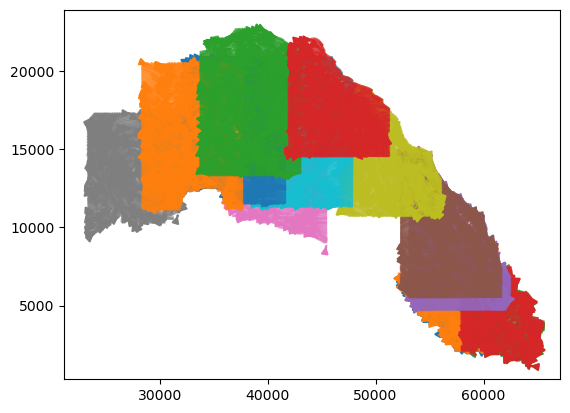

In [8]:
test_eddies = et.detection_nencioli_winding.detect_UV_core(data_aligned, 
                           det_param.copy(), 
                           data_aligned["UVEL"].compute(), 
                           data_aligned["VVEL"].compute(), 
                           data_aligned["SPEED"].compute(), 
                           t_index, 
                           data_aligned['dxC'].values, 
                           data_aligned['dyC'].values)

# Plotting eddy cores

In [9]:
def plot_map_eddies(snapshot_vel, snapshot_eddies, title, stream_density = 6):
    x_plot, y_plot = np.meshgrid(snapshot_vel['lon'], snapshot_vel['lat'])
    u_plot = snapshot_vel['UVEL'].values
    v_plot = snapshot_vel['VVEL'].values
    
    plt.close('all')
    fig = plt.figure(figsize=(12, 7))

    # Plot background scalar field (e.g., UVEL)
    snapshot_vel["UVEL"].plot()

    # Plot streamlines
    plt.streamplot(x_plot, y_plot, u_plot, v_plot, 
                   density=stream_density, color='black', linewidth=0.5, 
                   arrowsize=0.7, arrowstyle='->')

    # Overlay eddies
    for i in range(len(snapshot_eddies)):
        
        if snapshot_eddies[i]['valid_eddy'] == -1:
            plt.scatter(snapshot_eddies[i]['lon'], snapshot_eddies[i]['lat'], c='red')
            plt.text(snapshot_eddies[i]['lon'], snapshot_eddies[i]['lat'], f'{round(snapshot_eddies[i]["winding"],2)}')
            continue
            
        eddy_i = snapshot_eddies[i]['eddy_i']
        eddy_j = snapshot_eddies[i]['eddy_j']
        lon_eddy = snapshot_vel['lon'].values[eddy_i]
        lat_eddy = snapshot_vel['lat'].values[eddy_j]

        try:
            triang = tri.Triangulation(lon_eddy, lat_eddy)
            plt.tripcolor(triang, facecolors=np.full(len(triang.triangles), 1.0), 
                          cmap=plt.cm.Greens, vmin=0, vmax=4, alpha=1)
        except Exception as e:
            plt.scatter(lon_eddy, lat_eddy, c='green')
        # Eddy center
        plt.scatter(snapshot_eddies[i]['lon'], snapshot_eddies[i]['lat'], c='black')

    plt.text(0.02, 0.98, f'Z={round(float(snapshot_vel.Depth.values),2)}m', transform=plt.gca().transAxes, ha='left', va='top')
    plt.title(title)
    
    return fig

In [10]:
%matplotlib notebook
fig = plot_map_eddies(data_aligned.isel(time=t_index), test_eddies, '', stream_density = 8)

<IPython.core.display.Javascript object>

# Test streamlines

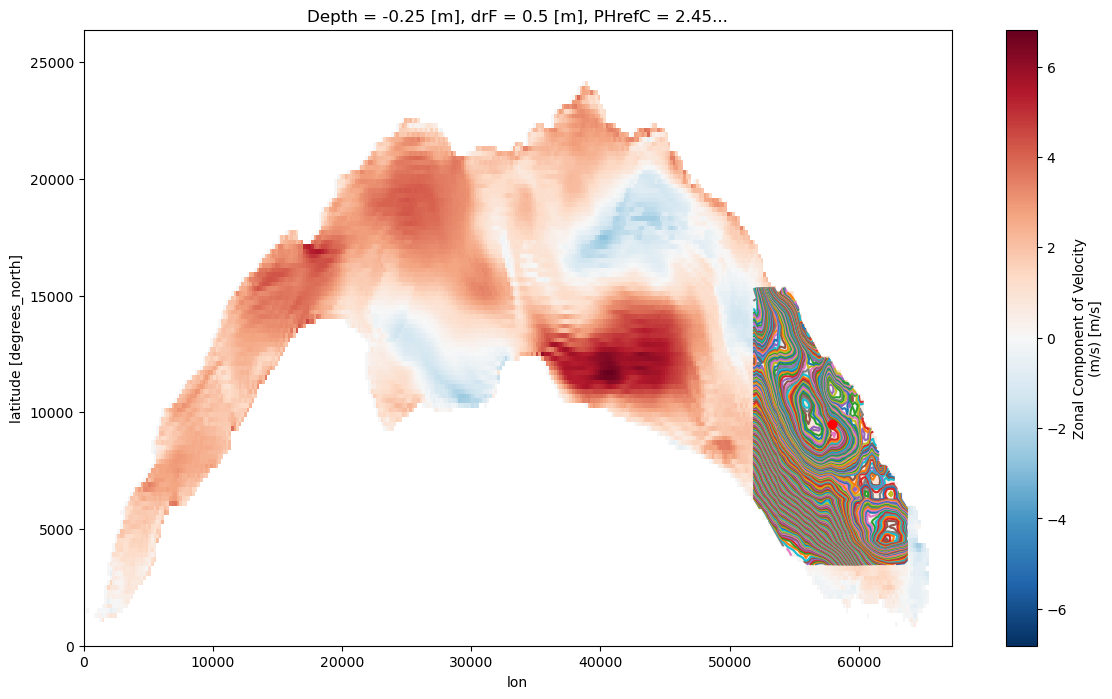

In [35]:
idx_eddy = 4
plt.figure(figsize=(14,8))
data_aligned.isel(time=t_index)['UVEL'].plot()
for i in test_eddies[idx_eddy]['isolines']:
    iso = test_eddies[idx_eddy]['isolines'][i]
    plt.plot(iso['x'], iso['y'])

plt.scatter(test_eddies[idx_eddy]['lon'], test_eddies[idx_eddy]['lat'],zorder=50, c='red')

In [8]:
def compute_psi(u, v, dx, dy):
    # compute PSI to get eddy area
    # itegrate first row of v along longitude (first term of eq.A2)
    v_without_nan = np.where(np.isnan(v), 0, v)
    u_without_nan = np.where(np.isnan(u), 0, u)
    cx = np.nancumsum(v_without_nan[0, :] * dx[0, :])
    # integrate first column of u along latitude (second term of eq.A3)
    cy = np.nancumsum(u_without_nan[:, 0] * dy[:, 0])
    # compute streamfunction
    # PSI from integrating v first and then u
    psi_xy = -cx[None, :] + np.nancumsum(u_without_nan * dy, axis=0)
    # PSI from integrating u first and then v
    psi_yx = -np.nancumsum(v_without_nan * dx, axis=1) + cy[:, None]
    # final PSI as average between the two
    psi = 0.5 * (psi_xy + psi_yx)

    return np.where(np.isnan(u), np.nan, psi)

In [9]:
snapshot = data_aligned.isel(time=t_index)
psi = compute_psi(snapshot['UVEL'].values, snapshot['VVEL'].values, snapshot['dxC'].values, snapshot['dyC'].values)
isolines, isolines_max = et.detection_nencioli_winding.generate_contours(snapshot['lat'].values, snapshot['lon'].values, psi, 50)

In [10]:
u = snapshot['UVEL'].values
v = snapshot['VVEL'].values
dx = snapshot['dxC'].values
dy = snapshot['dyC'].values

# compute PSI to get eddy area
# itegrate first row of v along longitude (first term of eq.A2)
v_without_nan = np.where(np.isnan(v), 0, v)
u_without_nan = np.where(np.isnan(u), 0, u)
cx = np.nancumsum(v_without_nan[0, :] * dx[0, :])
# integrate first column of u along latitude (second term of eq.A3)
cy = np.nancumsum(u_without_nan[:, 0] * dy[:, 0])
# compute streamfunction
# PSI from integrating v first and then u
psi_xy = -cx[None, :] + np.nancumsum(u_without_nan * dy, axis=0)
# PSI from integrating u first and then v
psi_yx = -np.nancumsum(v_without_nan * dx, axis=1) + cy[:, None]
# final PSI as average between the two
psi = 0.5 * (psi_xy + psi_yx)

psi_masked = np.where(np.isnan(u), np.nan, psi)

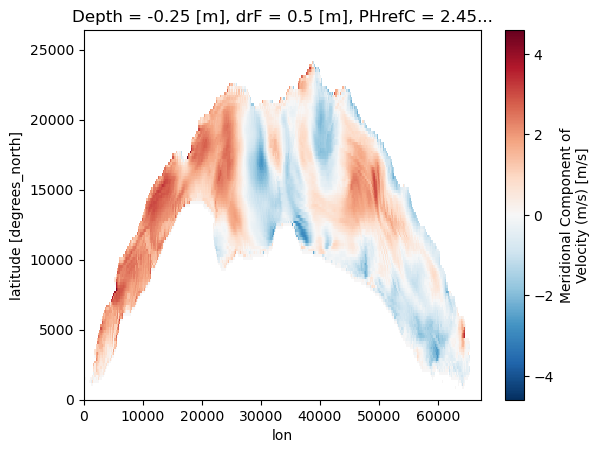

In [11]:
snapshot['VVEL'].plot()

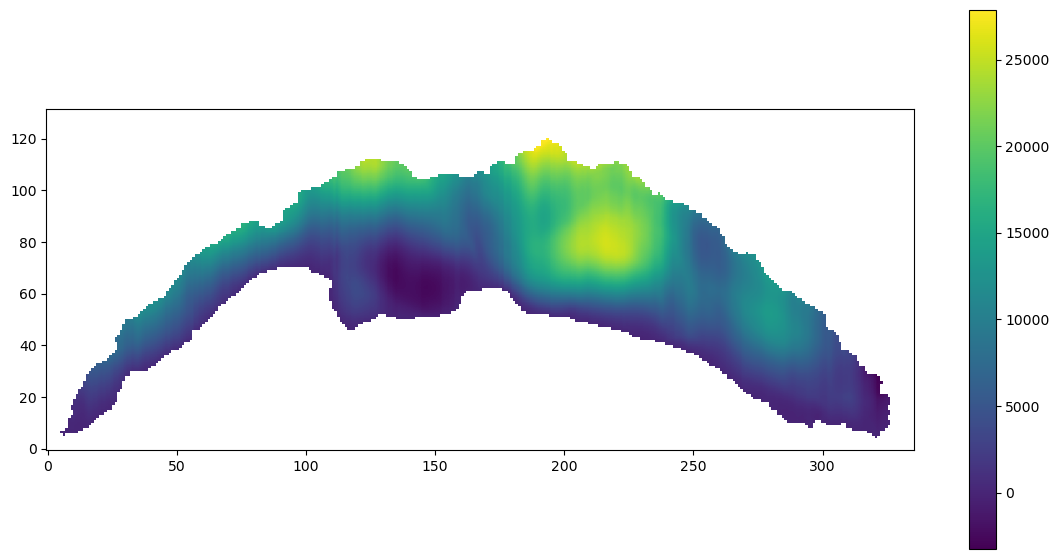

In [12]:
plt.figure(figsize=(14,7))
plt.imshow(np.where(np.isnan(u), np.nan, psi_xy))
plt.gca().invert_yaxis()
plt.colorbar()

In [13]:
psi_yx_without_nan = np.where(np.isnan(u), np.nan, psi_yx)

In [14]:
psi_yx_without_nan

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

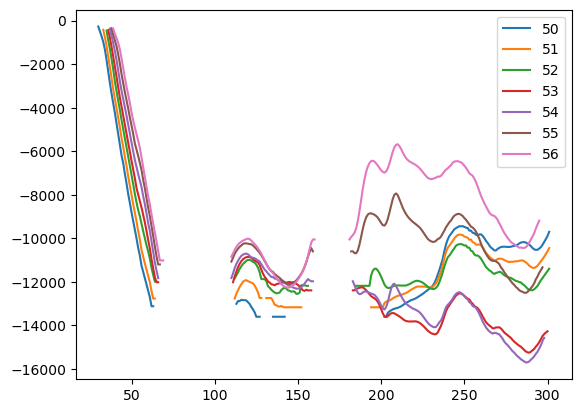

In [15]:
%matplotlib inline
plt.figure()
for i in range(50,57):
    plt.plot(psi_yx_without_nan[i,:], label=i)
    plt.legend()

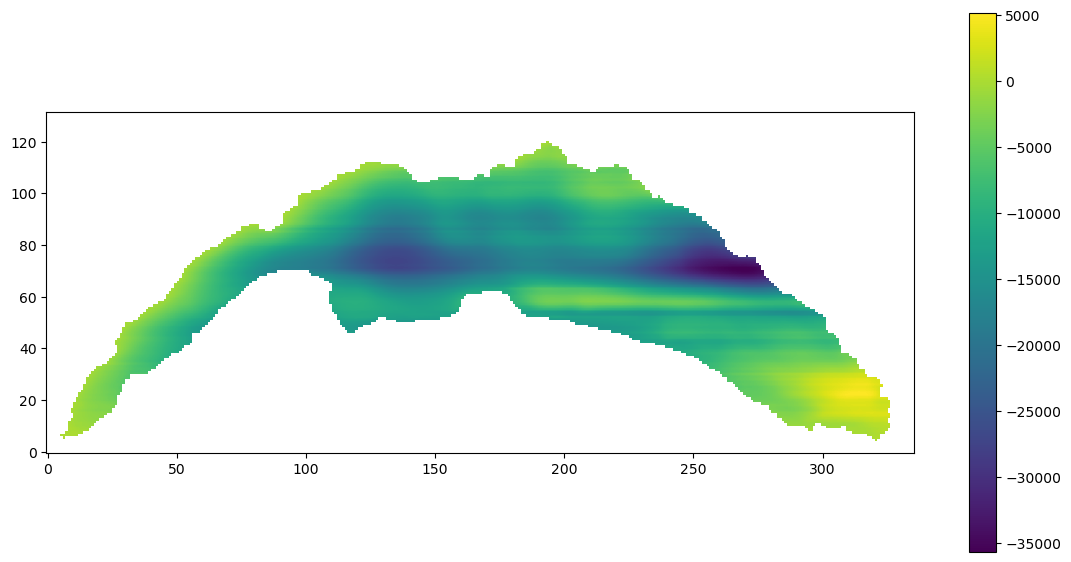

In [16]:
#%matplotlib notebook
plt.figure(figsize=(14,7))
plt.imshow(np.where(np.isnan(u), np.nan, psi_yx))
plt.gca().invert_yaxis()
plt.colorbar()

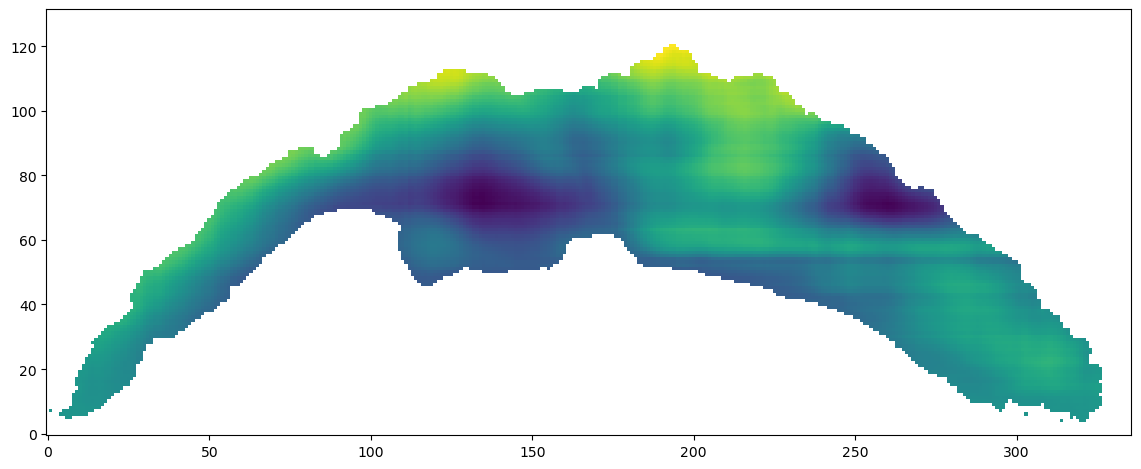

In [42]:
plt.figure(figsize=(14,7))
plt.imshow(psi)
plt.gca().invert_yaxis()

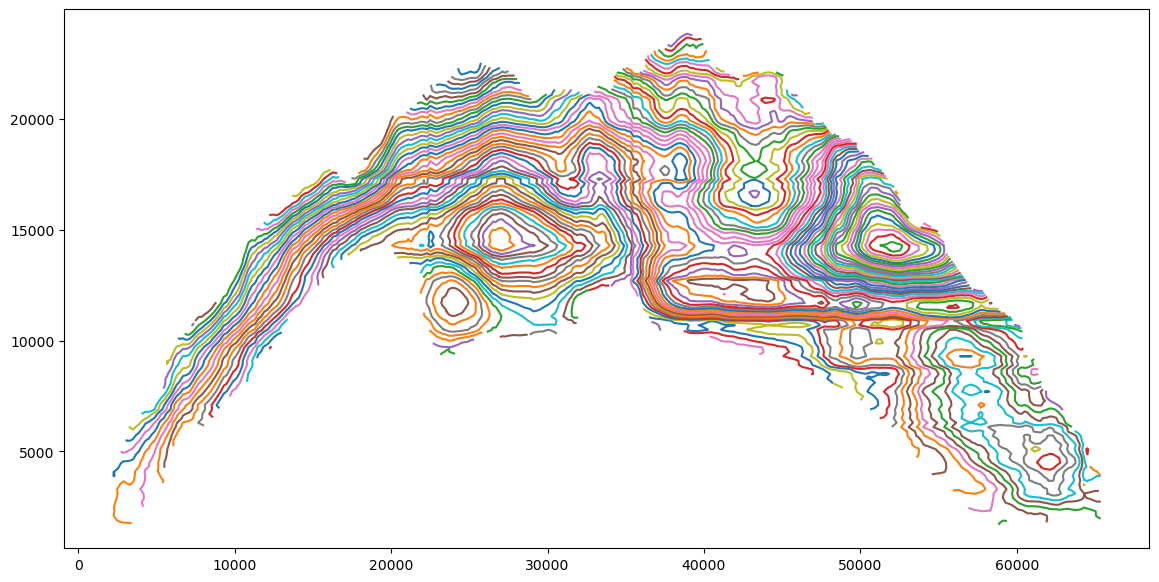

In [17]:
plt.figure(figsize=(14,7))
for i in isolines:
    iso = isolines[i]
    plt.plot(iso['x'], iso['y'])

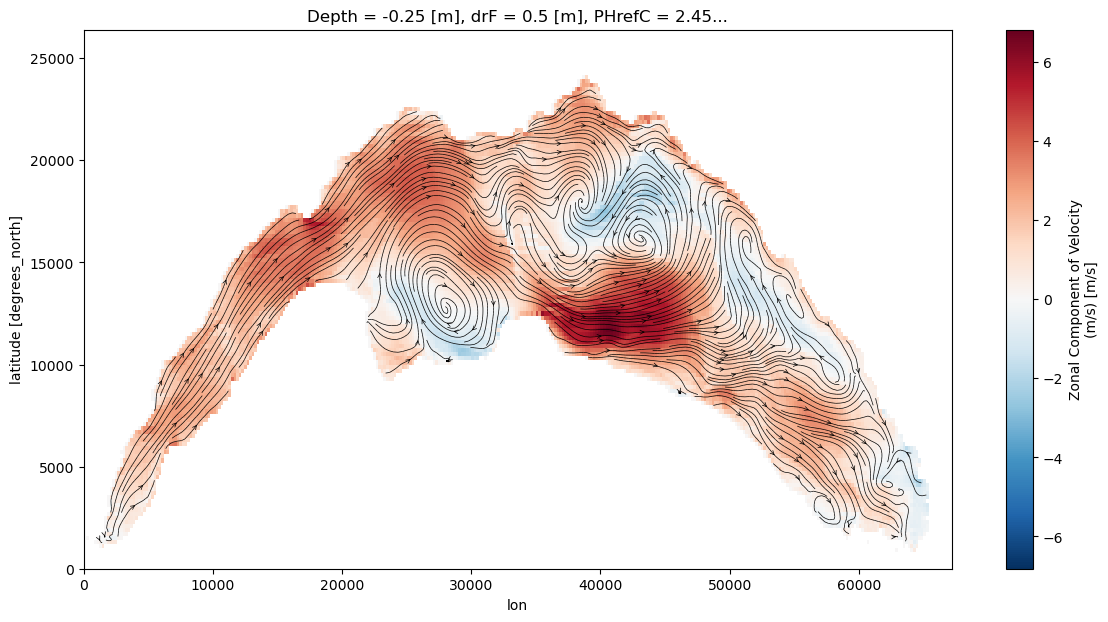

In [10]:
snapshot = data_aligned.isel(time=t_index)
x_plot, y_plot = np.meshgrid(snapshot['lon'], snapshot['lat'])
u_plot = snapshot['UVEL'].values
v_plot = snapshot['VVEL'].values

plt.close('all')
fig = plt.figure(figsize=(14, 7))

# Plot background scalar field (e.g., UVEL)
snapshot["UVEL"].plot()

# Plot streamlines
stream_plot = plt.streamplot(x_plot, y_plot, u_plot, v_plot, 
               density=6, color='black', linewidth=0.5, 
               arrowsize=0.7, arrowstyle='->')

In [29]:
%matplotlib notebook
plt.figure(figsize=(14,7))

for i in isolines:
    iso = isolines[i]
    plt.plot(iso['x'], iso['y'])

subsetting_factor_x = 4
subsetting_factor_y = 2
ds_to_plot = data_aligned
X_trimmed = ds_to_plot['lon'][::subsetting_factor_x]
Y_trimmed = ds_to_plot['lat'][::subsetting_factor_y]
U_trimmed = ds_to_plot['UVEL'].isel(time=t_index)[:,1:][::subsetting_factor_y,::subsetting_factor_x]
V_trimmed = ds_to_plot['VVEL'].isel(time=t_index)[1:,:][::subsetting_factor_y,::subsetting_factor_x]

stream_plot = plt.streamplot(x_plot, y_plot, u_plot, v_plot, 
               density=6, color='black', linewidth=0.5, 
               arrowsize=0.7, arrowstyle='->')

U_trimmed = U_trimmed.where(U_trimmed != 0, np.nan)
V_trimmed = V_trimmed.where(V_trimmed != 0, np.nan)
plt.quiver(X_trimmed, Y_trimmed, U_trimmed, V_trimmed, scale=80, zorder=50)

<IPython.core.display.Javascript object>

In [230]:
%matplotlib notebook
plt.figure()
for i in isolines:
    iso = isolines[i]
    plt.plot(iso['x'], iso['y'])

<IPython.core.display.Javascript object>

In [91]:
x_plot[100:170,40:110]

array([[ 8100.,  8300.,  8500., ..., 21500., 21700., 21900.],
       [ 8100.,  8300.,  8500., ..., 21500., 21700., 21900.],
       [ 8100.,  8300.,  8500., ..., 21500., 21700., 21900.],
       ...,
       [ 8100.,  8300.,  8500., ..., 21500., 21700., 21900.],
       [ 8100.,  8300.,  8500., ..., 21500., 21700., 21900.],
       [ 8100.,  8300.,  8500., ..., 21500., 21700., 21900.]])

In [110]:
plt.figure()
zoom = np.s_[40:110, 100:170]
stream_plot = plt.streamplot(x_plot[zoom], y_plot[zoom], u_plot[zoom], v_plot[zoom], 
               density=8, color='black', linewidth=0.5, 
               arrowsize=0.7, arrowstyle='->')

<IPython.core.display.Javascript object>

In [111]:
seen = set()
unique_segments = []

for segment in stream_plot.lines.get_segments():
    rounded = np.round(segment, decimals=0)
    key = rounded.tobytes()  # Fast hashable representation
    if key not in seen:
        seen.add(key)
        unique_segments.append(rounded)

In [72]:
from scipy.spatial import cKDTree

def build_streamlines(segments, tol=1e0):
    # Each segment is a (2, 2) array: [[x1, y1], [x2, y2]]
    start_points = np.array([seg[0] for seg in segments])
    used = np.zeros(len(segments), dtype=bool)

    # Build KDTree for fast spatial search
    start_points_tree = cKDTree(start_points)

    streamlines = []

    for i in range(len(segments)):
        if used[i]:
            continue
        streamline = [segments[i][0], segments[i][1]]
        used[i] = True
        end = segments[i][1]

        # Follow the chain forward
        while True:
            dists, idxs = start_points_tree.query(end, k=5, distance_upper_bound=tol)
            found = False
            for dist, idx in zip(dists, idxs):
                if idx == len(start_points) or used[idx]:
                    continue
                if np.linalg.norm(start_points[idx] - end) < tol:
                    streamline.append(segments[idx][1])
                    used[idx] = True
                    found = True
                    end = segments[idx][1]
                    break
            if not found:
                break

        streamlines.append(np.array(streamline))

    return streamlines

In [112]:
lines = build_streamlines(unique_segments)

In [165]:
[line[:, 1].max() for line in lines]

[21697.0,
 21689.0,
 21317.0,
 20631.0,
 21900.0,
 21900.0,
 21900.0,
 19826.0,
 21900.0,
 21900.0,
 21900.0,
 21900.0,
 21900.0,
 21900.0,
 21900.0,
 21831.0,
 21698.0,
 21478.0,
 21243.0,
 21080.0,
 21232.0,
 20917.0,
 20552.0,
 20424.0,
 20303.0,
 20149.0,
 20058.0,
 19966.0,
 19820.0,
 19711.0,
 19615.0,
 19537.0,
 16823.0,
 19616.0,
 17394.0,
 19369.0,
 17974.0,
 19558.0,
 17798.0,
 17512.0,
 17218.0,
 16467.0,
 19357.0,
 16291.0,
 19153.0,
 17275.0,
 16000.0,
 18858.0,
 18759.0,
 16217.0,
 13684.0,
 16306.0,
 14152.0,
 13804.0,
 16441.0,
 14219.0,
 16595.0,
 14496.0,
 16740.0,
 16866.0,
 16972.0,
 17073.0,
 14685.0,
 17178.0,
 17267.0,
 14922.0,
 17393.0,
 17484.0,
 17625.0,
 15499.0,
 17777.0,
 15612.0,
 17897.0,
 17991.0,
 18167.0,
 16017.0,
 18288.0,
 15931.0,
 16645.0,
 17005.0,
 17167.0,
 17338.0,
 17515.0,
 17632.0,
 18405.0,
 17927.0,
 17986.0,
 18102.0,
 18160.0,
 18277.0,
 18335.0,
 18572.0,
 18665.0,
 18690.0,
 18749.0,
 18926.0,
 18985.0,
 19043.0,
 19225.0,
 19287.0,


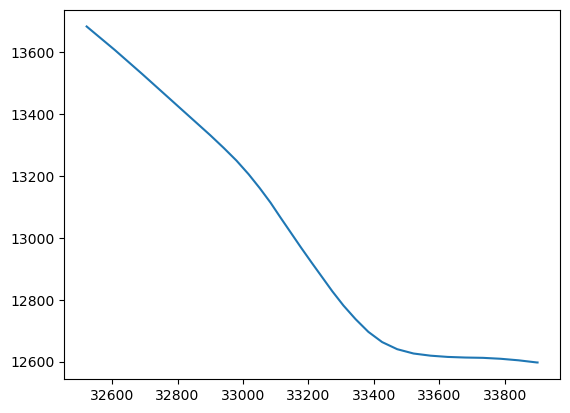

In [113]:
%matplotlib inline
plt.figure()
i=50
plt.plot(lines[i][:,0],lines[i][:,1])

In [114]:
%matplotlib notebook
plt.figure(figsize=(14,7))
for i in range(len(lines)):
    plt.plot(lines[i][:,0],lines[i][:,1])

<IPython.core.display.Javascript object>

In [76]:
def check_winding_angle(isoline_x, isoline_y, winding_thres=360, baddir_thres=90, d_thres=5):
    """
    Detects eddies in a streamline by analyzing its winding angle.

    Parameters:
        isoline_x (array-like): X coordinates of the isoline.
        isoline_y (array-like): Y coordinates of the isoline.
        winding_thres (float): Threshold winding angle to declare an eddy (degrees).
        baddir_thres (float): Threshold for angle deviation in wrong direction (degrees).
        d_thres (float): Distance threshold for closed loop detection.

    Returns:
        (bool, float): (eddy_detected, total_winding_angle)
    """
    winding = 0.0
    baddir = 0.0
    dir_sign = 0
    eddy = False
    min_dist = float('inf')

    # Initial direction
    dx0 = isoline_x[1] - isoline_x[0]
    dy0 = isoline_y[1] - isoline_y[0]
    prev_angle = np.degrees(np.arctan2(dy0, dx0))

    for i in range(1, len(isoline_x) - 1):
        angle_diff, prev_angle, winding = et.detection_nencioli_winding.increment_winding_angle(i, prev_angle, isoline_x, isoline_y, winding)

        if not et.detection_nencioli_winding.check_direction_consistency(angle_diff, baddir, baddir_thres, dir_sign):
            break
        
        # Eddy detection logic
        if abs(winding) > winding_thres:
            dist_to_start = np.hypot(isoline_x[i] - isoline_x[0], isoline_y[i] - isoline_y[0])
            if eddy and dist_to_start > min_dist:
                break
            if dist_to_start < d_thres:
                eddy = True
                min_dist = dist_to_start

    return eddy, winding

In [156]:
%matplotlib notebook
plt.figure()
i_line=306
eddy, winding = check_winding_angle(lines[i_line][:,0], lines[i_line][:,1], winding_thres=360, baddir_thres=90, d_thres=1000)
print(eddy)
plt.plot(lines[i_line][:,0],lines[i_line][:,1], marker='o')
plt.text(0.02, 0.98, f'winding={round(winding,0)}°', transform=plt.gca().transAxes, ha='left', va='top')

<IPython.core.display.Javascript object>

True


Text(0.02, 0.98, 'winding=-361.0°')

In [166]:
from scipy.spatial import ConvexHull
from matplotlib.path import Path

In [168]:
x_isoline = lines[i_line][:,0] # vertex lon's ,
y_isoline = lines[i_line][:,1] # vertex lat's
p = np.array([x_isoline, y_isoline]).T
hullp = ConvexHull(p)
poly_path = Path(p[hullp.vertices])

In [160]:
plt.figure()
i_lines = [171, 193, 212, 226, 306, 315, 318, 319, 321, 327]
for idx in i_lines:
    plt.plot(lines[idx][:, 0], lines[idx][:, 1], marker='o')

<IPython.core.display.Javascript object>

In [79]:
winding

135.0

In [151]:
eddies_winding = []
winding_streamlines = []
for i_line in range(len(lines)):
    eddy, winding = check_winding_angle(lines[i_line][:,0], lines[i_line][:,1], winding_thres=360, baddir_thres=90, d_thres=1000)
    eddies_winding.append(eddy)
    winding_streamlines.append(winding)

In [152]:
eddies_winding[306]

True

In [154]:
np.where(eddies_winding)

(array([171, 193, 212, 226, 306, 315, 318, 319, 321, 327]),)

In [144]:
np.where(winding_streamlines > 360*np.ones(1))

(array([212]),)

In [138]:
np.where(winding_streamlines < -360*np.ones(1))

(array([171, 193, 226, 306, 315, 318, 319, 321, 327]),)